## IMAGE CLASSIFIER using CONVULATIONAL NEURAL NETWORK

Rohan Ghosh Dastidar <br>
22CH30028 <br>
Assignment 5


## 1. Install dependencies and setup

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

Avoid "Out of Memory" Errros by setting GPU memory consumption growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Get rid of dodgy/invalid images

In [3]:
import cv2
import imghdr

C:\Users\minag\AppData\Local\Temp\ipykernel_13920\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'

In [5]:
# List of approved image extensions that the model can process
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    print(image_class)

benign
malignant


### Reading an image as a Numpy array

In [7]:
img = cv2.imread(os.path.join('beign', '10253_idx5_x1051_y951_class0.png'))

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path)) 

## 3. Load Data

In [9]:
# BUILDING THE ML PIPELINE

data = tf.keras.utils.image_dataset_from_directory('data', image_size = (50, 50))
print(data.class_names)

# Iterator that loops through the dataset and pulls the data in batches
data_iterator = data.as_numpy_iterator()

# Accessing the data pipeline
batch = data_iterator.next()

Found 1724 files belonging to 2 classes.
['benign', 'malignant']


### Benign . . . 0
### Malignant . . . 1

In [10]:
# Images represented as numpy arrays
batch[0].shape

(32, 50, 50, 3)

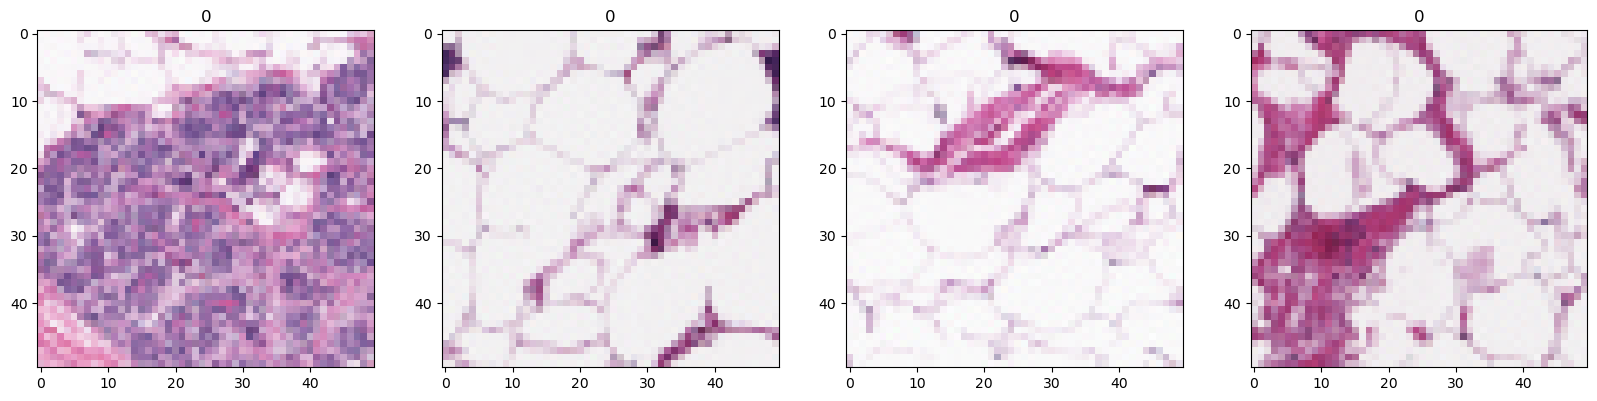

In [11]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 4. Image Pre-Processing

In [12]:
batch_min = batch[0].min()
print(batch_min)

batch_max = batch[0].max()
print(batch_max)

scaled = batch[0]/255
print(scaled.max())


13.0
255.0
1.0


### Scale data

In [13]:
data =  data.map(lambda x, y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [14]:
batch[0].min()

0.043137256

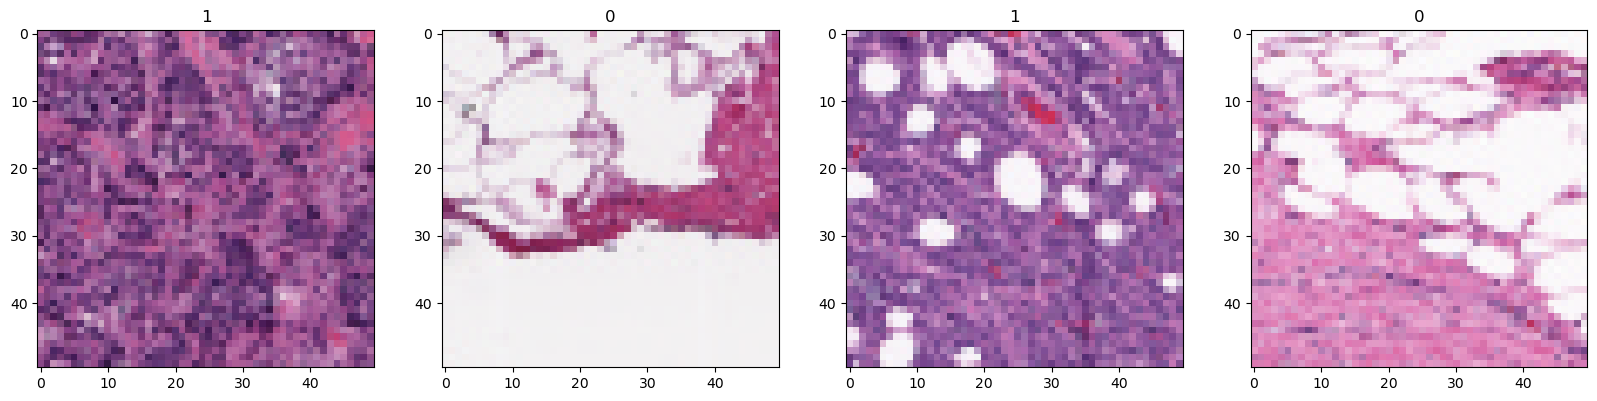

In [15]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split Data

In [16]:
# Size of each batch of data
len(data)

54

In [17]:
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

print(train_size + validation_size + test_size)

54


In [18]:
# Retrieve a specified number of elements (batches) from a dataset
train = data.take(train_size)
val = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

## Building the Deep Learning Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()

# Layer with "16 filters" with "3x3 pixels size", moving by "1 pixel" activated by "ReLu activation"
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

# FLATTEN LAYER
model.add(Flatten())

# TWO DENSE LAYERS
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Sigmoid activation to classify the output between 0 and 1

d:\Anaconda.org\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimizer = Adam (Adaptive Moment Estimation) optimizer <br>
Loss function = Binary cross-entropy <br>
Tracking metric = Keras will track the "accuracy" of the model

In [20]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,761 (295.94 KB)

 Trainable params: 75,761 (295.94 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [22]:
# TensorBoard callback - used for monitoring the training process of the model in real time.
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
hist = model.fit(train, epochs = 40, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6761 - loss: 0.5515 - val_accuracy: 0.8409 - val_loss: 0.3930
Epoch 2/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8570 - loss: 0.3710 - val_accuracy: 0.8807 - val_loss: 0.3881
Epoch 3/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8829 - loss: 0.3315 - val_accuracy: 0.8722 - val_loss: 0.3449
Epoch 4/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8997 - loss: 0.2972 - val_accuracy: 0.8750 - val_loss: 0.3595
Epoch 5/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9099 - loss: 0.2691 - val_accuracy: 0.9062 - val_loss: 0.3274
Epoch 6/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9121 - loss: 0.2559 - val_accuracy: 0.8750 - val_loss: 0.3568
Epoch 7/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8980 - loss: 0.2869 - val_accuracy: 0.8722 - val_loss: 0.3296
Epoch 8/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9072 - loss: 0.2747 - val_accuracy: 0.9034 - v

### Plot performance of the model

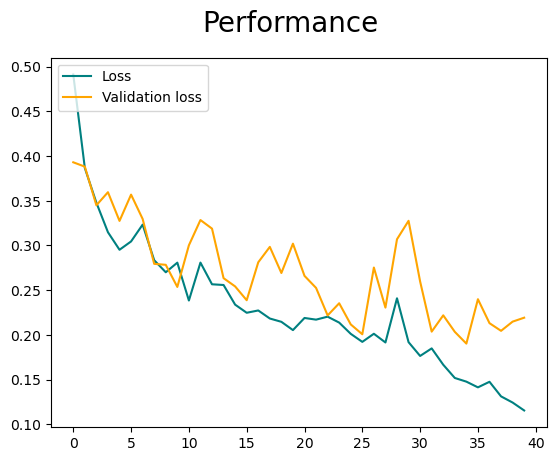

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'Loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'Validation loss')

fig.suptitle('Performance', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

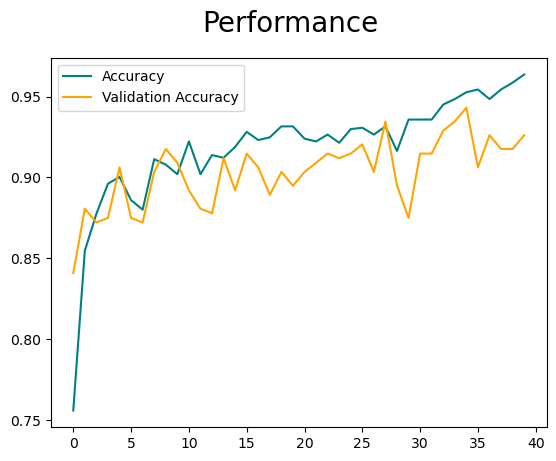

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'Accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'Validation Accuracy')

fig.suptitle('Performance', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

### Evaluating Performance of the Model

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
precision_ = Precision()
recall_ = Recall()
accuracy_ = BinaryAccuracy()

In [27]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision_.update_state(y, yhat)
    recall_.update_state(y, yhat)
    accuracy_.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


### PERFORMANCE of the Model

In [28]:
print(f"Precision = {precision_.result().numpy()}")
print(f"Recall = {recall_.result().numpy()}")
print(f"Accuracy = {accuracy_.result().numpy()}")

Precision = 0.8142856955528259
Recall = 0.890625
Accuracy = 0.8936170339584351


## Testing the model on "Testing" dataset

### Drawing the images from "test" folder and performing the prediction of all the images

In [29]:
test_folder = 'test'
results = []

# Loop through each image file in the test folder
for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)

    img = cv2.imread(image_path)
    resize = tf.image.resize(img, (50, 50))
    y_hat = model.predict(np.expand_dims(resize / 255, axis=0))

    if y_hat > 0.5:
        print(f"Image '{image_name}' classified as MALIGNANT TUMOR")
        prediction = "Malignant"
    else:
        print(f"Image '{image_name}' classified as BENIGN TUMOR")
        prediction = "Benign"

    results.append([image_name, prediction])

df = pd.DataFrame(results, columns = ["Image", "Prediction"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 'eight.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 'eleven.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image 'five.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 'four.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 'fourteen.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image 'nine.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image 'one.png' classified as BENIGN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 'seven.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image 'six.png' classified as BENIGN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 'ten.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image 'thirteen.png' classified as MALIGNANT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image 'three.png' classi

In [30]:
print(df)

           Image Prediction
0      eight.png  Malignant
1     eleven.png  Malignant
2       five.png  Malignant
3       four.png  Malignant
4   fourteen.png  Malignant
5       nine.png  Malignant
6        one.png     Benign
7      seven.png  Malignant
8        six.png     Benign
9        ten.png  Malignant
10  thirteen.png  Malignant
11     three.png  Malignant
12    twelve.png     Benign
13       two.png     Benign
